In [1]:
# Import all tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# ignore warning 
import warnings
warnings.filterwarnings("ignore")

In [36]:
# Define all core methods used
def clean_data(df):
    data = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST']]
    data['HSGR'] = data['FTHG']/data['HS']
    data['ASGR'] = data['FTAG']/data['AS']
    data = data.replace([np.inf, -np.inf], 0)
    bet_home = df[['B365H','BWH','IWH','PSH','VCH','WHH']].mean(axis=1)
    bet_draw = df[['B365D','BWD','IWD','PSD','VCD','WHD']].mean(axis=1)
    bet_away = df[['B365A','BWA','IWA','PSA','VCA','WHA']].mean(axis=1)
    data['odd_home'] = bet_home
    data['odd_draw'] = bet_draw
    data['odd_away'] = bet_away
    data.dropna()
    return data

def restructure(df):
    df = df.copy()
    df['goals_h_a'] = df['FTHG'] - df['FTAG']
    df['total_h_a'] = df['HS'] - df['AS']

    H_GT = [] # home games total so far
    H_W = [] # home wins so far
    H_WR = [] # home win rate so far
    H_avg_diff = [] # home avg goals diff

    A_GT = [] # away games total so far
    A_W = [] # away wins so far
    A_WR = [] #away win rate so far
    A_avg_diff = [] # away avg goals diff

    for i in range(len(df)):
        home = df.loc[i, 'HomeTeam']
        away = df.loc[i, 'AwayTeam']
        
        home_h_games = df[df['HomeTeam'] == home].loc[:i-1]['goals_h_a']
        home_a_games = df[df['AwayTeam'] == home].loc[:i-1]['goals_h_a'] * -1
        home_games = home_h_games.append(home_a_games)
        
        away_h_games = df[df['HomeTeam'] == away].loc[:i-1]['goals_h_a']
        away_a_games = df[df['AwayTeam'] == away].loc[:i-1]['goals_h_a'] * -1
        away_games = away_h_games.append(away_a_games)
        
        H_GT.append(len(home_games))
        A_GT.append(len(away_games))
        
        H_W.append((home_games > 0).sum() + (home_games == 0).sum() * 0.5)
        A_W.append((away_games > 0).sum() + (away_games == 0).sum() * 0.5)
        
        if H_GT[i] > 0:
            H_WR.append(H_W[i] / H_GT[i])
            H_avg_diff.append(home_games.mean())
        else:
            H_WR.append(0)
            H_avg_diff.append(0)
            
        if A_GT[i] > 0:
            A_WR.append(A_W[i] / A_GT[i])
            A_avg_diff.append(away_games.mean())
        else:
            A_WR.append(0)
            A_avg_diff.append(0)
    
    df['H_GT'] = H_GT
    df['H_W'] = H_W
    df['H_WR'] = H_WR
    df['H_avg_diff'] = H_avg_diff
    df['A_GT'] = A_GT
    df['A_W'] = A_W
    df['A_WR'] = A_WR
    df['A_avg_diff'] = A_avg_diff
    return df

def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

def getLastTeamStats(df):
    team_stats = {}
    for team in df.HomeTeam.unique():
        temp_df = df[::-1].reset_index(drop=True)
        for i in range(len(temp_df)):
            game = temp_df.loc[i]
            if team == game['HomeTeam']:
                stats = {}
                stats['W'] = game['H_W']
                stats['WR'] = game['H_WR']
                stats['avg_diff'] = game['H_avg_diff']
                team_stats[team] = stats
            elif team == game['AwayTeam']:
                stats = {}
                stats['W'] = game['A_W']
                stats['WR'] = game['A_WR']
                stats['avg_diff'] = game['A_avg_diff']
                team_stats[team] = stats
            if team in team_stats:
                break
    return team_stats

In [67]:
# Clean and restructure all the data
data_1415 = clean_data(pd.read_csv('./data/1415.csv'))
data_1415.drop(data_1415.tail(1).index,inplace=True)
data_1516 = clean_data(pd.read_csv('./data/1516.csv'))
data_1617 = clean_data(pd.read_csv('./data/1617.csv'))
data_1718 = clean_data(pd.read_csv('./data/1718.csv'))
data_1819 = clean_data(pd.read_csv('./data/1819.csv'))

df_1415 = restructure(data_1415)
df_1516 = restructure(data_1516)
df_1617 = restructure(data_1617)
df_1718 = restructure(data_1718)
df_1819 = restructure(data_1819)

df_past_seasons = df_1415.copy()
df_past_seasons = df_past_seasons.append(df_1516)
df_past_seasons = df_past_seasons.append(df_1617)
df_past_seasons = df_past_seasons.append(df_1718)
df_past_seasons = df_past_seasons.reset_index(drop=True)
df_past_seasons = df_past_seasons[['HomeTeam', 'AwayTeam', 
                                   'H_W', 'H_WR', 'H_avg_diff', 
                                   'A_W', 'A_WR', 'A_avg_diff', 
                                   'odd_home', 'odd_draw', 'odd_away']]

df_future_games = pd.read_csv('./data/prediction.csv')

In [39]:
scaler = MinMaxScaler()
knn_reg = KNeighborsRegressor()

columns_to_use = ['H_W', 'H_WR', 'H_avg_diff', 'A_W', 'A_WR', 'A_avg_diff']

## K-Neighbors Regression with Scaler and 10-Fold Cross Validation

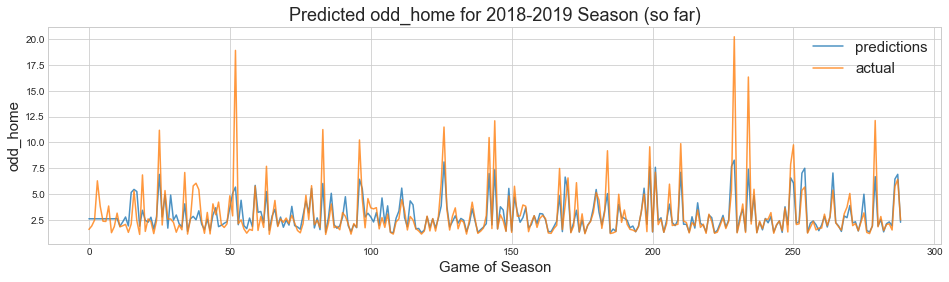

odd_home , neg MAE:  -0.821804049724465


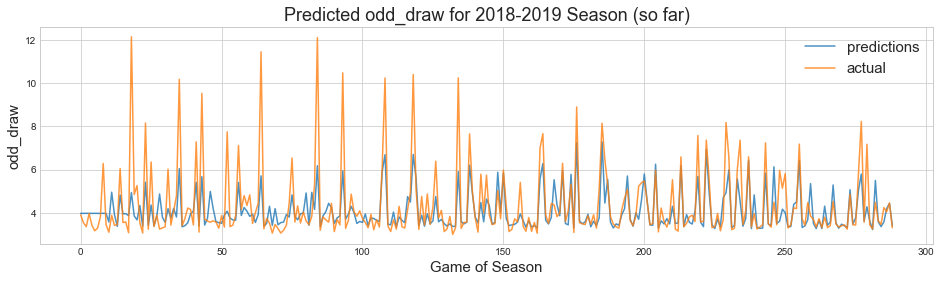

odd_draw , neg MAE:  -0.645195167850422


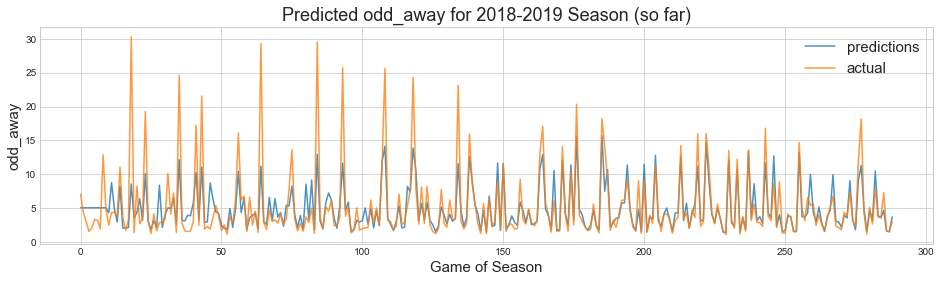

odd_away , neg MAE:  -1.6805184240879012


In [129]:
# GRID SEARCH (K-NEIGHBORS REGRESSOR, SCALER)

pipe = make_pipeline(scaler, knn_reg)
param_grid = {
    'kneighborsregressor__n_neighbors':range(1, 20), 
    'kneighborsregressor__weights':['uniform', 'distance']
}
grid = GridSearchCV(pipe, param_grid, cv=10, scoring="neg_mean_absolute_error")

for odd_type in ['odd_home', 'odd_draw', 'odd_away']:
    grid.fit(df_past_seasons[columns_to_use], df_past_seasons[odd_type])
    predictions = grid.predict(df_1819[columns_to_use])
    score = grid.score(df_1819[columns_to_use], df_1819[odd_type])
    
    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(len(predictions)), predictions, alpha=0.8, label='predictions')
    plt.plot(np.arange(len(predictions)), df_1819[odd_type].values, alpha=0.8, label='actual')
    plt.title('Predicted '+odd_type+' for 2018-2019 Season (so far)', fontsize=18)
    plt.xlabel('Game of Season', fontsize=15)
    plt.ylabel(odd_type, fontsize=15)
    plt.legend(fontsize=15)
    plt.show()
    print(odd_type, ', neg MAE: ', score)

## Multivariate Linear Regression with Forward Selection

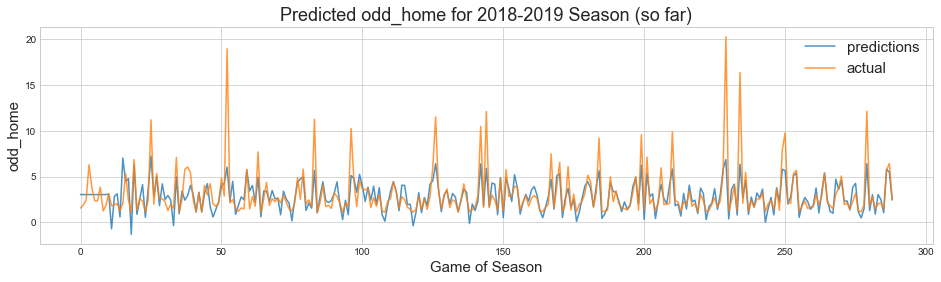

odd_home , neg MAE:  -1.0074253538704099


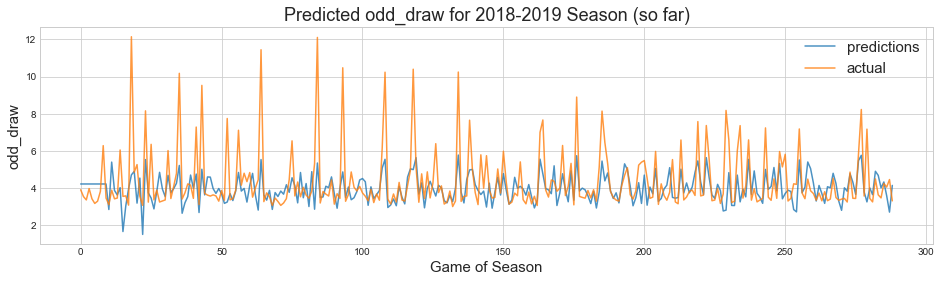

odd_draw , neg MAE:  -0.9187168020761359


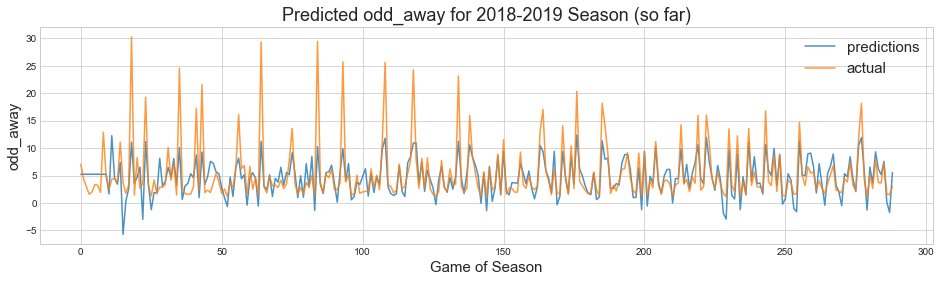

odd_away , neg MAE:  -2.234560739741936


In [128]:
# FORWARD SELECTION

for odd_type in ['odd_home', 'odd_draw', 'odd_away']:
    lin_model = forward_selected(df_past_seasons[np.append(columns_to_use, odd_type)], odd_type)
    predictions = lin_model.predict(df_1819[np.append(columns_to_use, odd_type)])
    score = 0-mean_absolute_error(df_1819[odd_type].values, predictions.values)

    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(len(predictions)), predictions, alpha=0.8, label='predictions')
    plt.plot(np.arange(len(predictions)), df_1819[odd_type].values, alpha=0.8, label='actual')
    plt.title('Predicted '+odd_type+' for 2018-2019 Season (so far)', fontsize=18)
    plt.xlabel('Game of Season', fontsize=15)
    plt.ylabel(odd_type, fontsize=15)
    plt.legend(fontsize=15)
    plt.show()
    print(odd_type, ', neg MAE: ', score)

In [97]:
team_stats = getLastTeamStats(df_1819)
H_W = []
H_WR = []
H_avg_diff = []
A_W = []
A_WR = []
A_avg_diff = []

for i in range(len(df_future_games)):
    game = df_future_games.loc[i]
    H_W.append(team_stats[game['HomeTeam']]['W'])
    H_WR.append(team_stats[game['HomeTeam']]['WR'])
    H_avg_diff.append(team_stats[game['HomeTeam']]['avg_diff'])
    A_W.append(team_stats[game['AwayTeam']]['W'])
    A_WR.append(team_stats[game['AwayTeam']]['WR'])
    A_avg_diff.append(team_stats[game['AwayTeam']]['avg_diff'])

df_future_games['H_W'] = H_W
df_future_games['H_WR'] = H_WR
df_future_games['H_avg_diff'] = H_avg_diff
df_future_games['A_W'] = A_W
df_future_games['A_WR'] = A_WR
df_future_games['A_avg_diff'] = A_avg_diff

higher_wr = []
for i in range(len(df_future_games)):
    if df_future_games.loc[i, 'H_WR'] > df_future_games.loc[i, 'A_WR']:
        higher_wr.append('H')
    elif df_future_games.loc[i, 'H_WR'] < df_future_games.loc[i, 'A_WR']:
        higher_wr.append('A')
    else:
        higher_wr.append('D')
df_future_games['higher_wr'] = higher_wr

In [88]:
# PREDICT ODDS OF FUTURE GAMES USING GRIDSEARCH MODEL

pipe = make_pipeline(scaler, knn_reg)
param_grid = {
    'kneighborsregressor__n_neighbors':range(1, 20), 
    'kneighborsregressor__weights':['uniform', 'distance']
}
grid = GridSearchCV(pipe, param_grid, cv=10, scoring="neg_mean_absolute_error")

for odd_type in ['odd_home', 'odd_draw', 'odd_away']:
    grid.fit(df_past_seasons[columns_to_use], df_past_seasons[odd_type])
    predictions = grid.predict(df_future_games[columns_to_use])
    df_future_games['predicted_'+odd_type] = predictions

lower_odds = []
for i in range(len(df_future_games)):
    if df_future_games.loc[i, 'predicted_odd_home'] > df_future_games.loc[i, 'predicted_odd_away']:
        lower_odds.append('A')
    elif df_future_games.loc[i, 'predicted_odd_home'] < df_future_games.loc[i, 'predicted_odd_away']:
        lower_odds.append('H')
    else:
        lower_odds.append('D')
df_future_games['lower_odds'] = lower_odds

In [89]:
# Predicted odds of future games
df_future_games[['HomeTeam', 'AwayTeam', 
                 'H_WR', 'A_WR',
                 'predicted_odd_home', 'predicted_odd_draw', 'predicted_odd_away', 
                 'higher_wr', 'lower_odds']].head()

,HomeTeam,AwayTeam,H_WR,A_WR,predicted_odd_home,predicted_odd_draw,predicted_odd_away,higher_wr,lower_odds
0,Cardiff,West Ham,0.321429,0.464286,2.665556,3.300877,3.101404,A,H
1,Crystal Palace,Brighton,0.392857,0.370370,2.231759,3.344211,3.743860,H,H
2,Huddersfield,Bournemouth,0.196429,0.428571,3.110556,3.361754,2.630263,A,A
3,Leicester,Fulham,0.446429,0.232143,1.815000,3.637368,5.066667,H,H
4,Man City,Watford,0.821429,0.517857,1.380926,5.542368,10.513684,H,H


In [98]:
(df_future_games['higher_wr'] == df_future_games['lower_odds']).mean()

0.8111111111111111